# Задача 6. Компьютерное зрение: задача сегментации

- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.


- [x] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [x] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [x] Попробовать улучшить качество изменяя архитектуру.
- [ ] (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?
- [x] (**+3 балла**) Сделать unet с pretrained энкодером (можно взять vgg или resnet18/34), сравнить с предыдущими пунктами.

In [ ]:
!pip install torchmetrics

# Импорты

In [2]:
from copy import copy
import pandas as pd
import random
import seaborn as sns
import torch
import torch.utils.data
from torchmetrics import JaccardIndex

import os
from matplotlib import pyplot as plt
from pathlib import Path
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import io, transforms
from torchvision.transforms import functional
from tqdm.auto import tqdm, trange

In [3]:
torch.manual_seed(42)
random.seed(42)

# Датасет

In [ ]:
!gdown 11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe

In [ ]:
!unzip dataset.zip

#UNet

In [6]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, padding: int):
        super().__init__()
        self.double_conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv_block(x)


class Encoder(nn.Module):
    def __init__(self, in_channels: int, n_down: int, channels_factor: int = 2, padding: int = 1):
        super().__init__()

        self.enc_layers = nn.ModuleList([DoubleConvBlock(in_channels, in_channels * channels_factor, padding)])
        for _ in range(n_down):
            in_channels *= channels_factor
            self.enc_layers.append(
                nn.Sequential(
                    nn.MaxPool2d(2, 2),
                    DoubleConvBlock(in_channels, in_channels * channels_factor, padding),
                )
            )

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results


class Decoder(nn.Module):
    def __init__(self, in_channels: int, n_up: int, channels_divisor: int = 2, padding: int = 1):
        super().__init__()

        self.dec_layers = nn.ModuleList()
        for _ in range(n_up):
            out_channels = in_channels // channels_divisor
            self.dec_layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                DoubleConvBlock(in_channels, out_channels, padding),
            ]
            in_channels = out_channels

    def forward(self, x: torch.Tensor, residuals: list[torch.Tensor]) -> torch.Tensor:
        assert len(residuals) == len(self.dec_layers) // 2
        for (up_conv, double_conv), residual in zip(zip(self.dec_layers[::2], self.dec_layers[1::2]), residuals[::-1]):
            x = up_conv(x)

            h_diff = residual.size(dim=2) - x.size(dim=2)
            assert 0 <= h_diff <= 1
            w_diff = residual.size(dim=3) - x.size(dim=3)
            assert 0 <= w_diff <= 1
            if h_diff > 0 or w_diff > 0:
                x = nn.functional.pad(x, [0, w_diff, 0, h_diff])

            x = torch.cat([residual, x], dim=1)

            x = double_conv(x)
        return x


class UNET(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, n_levels: int = 4):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, n_down=n_levels)
        self.decoder = Decoder(in_channels=in_channels * (2 ** (n_levels + 1)),
                               n_up=n_levels)
        self.out_conv = nn.Conv2d(in_channels=in_channels * 2,
                                  out_channels=out_channels,
                                  kernel_size=1,
                                  padding=0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        x = self.out_conv(x)
        return x

#Классы декораторы для датасетов

In [86]:
from torchvision.io import read_image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = read_image(str(self.images[idx])) / 255
        mask = read_image(str(self.masks[idx])) / 255
        return image, mask


class ResizedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self._dataset = dataset
        self._transform = transforms.Resize((416, 288))

    def __len__(self):
        return len(self._dataset)

    def __getitem__(self, idx):
        image, mask = self._dataset[idx]
        return self._transform(image), self._transform(mask)


def display_images(images):
    _, axes = plt.subplots(ncols=len(images))
    for ax, image in zip(axes, images):
        ax.imshow(functional.to_pil_image(image))
        ax.axis("off")

image_paths = sorted(Path("dataset/images").iterdir())
mask_paths = sorted(Path("dataset/masks").iterdir())

In [10]:
def split_data(images, masks):
    test_ratio = 0.1
    test_length = int(len(images) * test_ratio)
    paths = list(zip(images, masks))
    images_paths, masks_paths = zip(*paths)
    train_images_paths = images_paths[test_length:]
    test_images_paths = images_paths[:test_length]
    train_masks_paths = masks_paths[test_length:]
    test_masks_paths = masks_paths[:test_length]
    return train_images_paths, test_images_paths, train_masks_paths, test_masks_paths


train_images_paths, test_images_paths, train_masks_paths, test_masks_paths = split_data(image_paths, mask_paths)

test_images = CustomDataset(images=test_images_paths, masks=test_masks_paths)
train_images = CustomDataset(images=train_images_paths, masks=train_masks_paths)
print(len(test_images))
print(len(train_images))

200
1800


# Содержимое

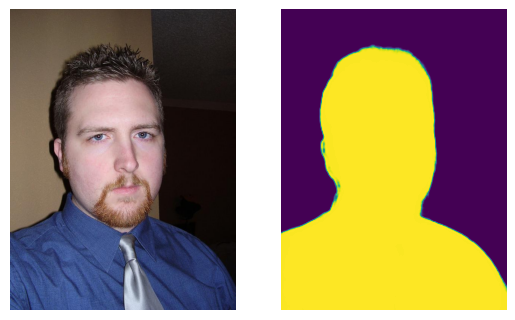

In [11]:
image, mask = train_images[0]
display_images([image, mask])

# Графики

In [12]:
def helper(statistic, title, ax):
    for _, row in statistic[statistic["Statistic"] == title].iterrows():
        ax.text(
            row["Epoch"],
            row["Value"],
            f"{row['Value']:.3f}",
            horizontalalignment="center",
            verticalalignment="bottom" if row["Dataset"] == "Train" else "top"
        )

def plot_statistics(statistic, title, values=True):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15, 7))

    for idx, (ax, stat) in enumerate(zip(axes, ["Loss", "Jaccard"])):
        data = statistic[statistic["Statistic"] == stat]
        sns.lineplot(data=data, x="Epoch", y="Value", hue="Dataset", marker="o", ax=ax)
        ax.set_title(stat)
        if values:
            helper(data, stat, ax)

    fig.suptitle(title)
    fig.tight_layout()

In [13]:
loss = nn.BCEWithLogitsLoss()
jaccard = JaccardIndex(task="binary")

In [66]:
def show_worst_test_cases(model, dataset=test_images, n=None, idx=None):
  if idx is None:
    test_metrics = []
    with torch.no_grad():
      for i, (X, y) in enumerate(dataset):
        prediction = model(X.cuda().unsqueeze(0))[0].cpu()
        test_metrics.append((jaccard(prediction.cpu(), y.cpu() > jaccard.threshold).item(), i))

        idx = [i for _, i in sorted(test_metrics)[:n]]

  with torch.no_grad():
    for i in idx:
      X, y = dataset[i]
      prediction = model(X.cuda().unsqueeze(0))[0].cpu()
      display_images([X, nn.functional.sigmoid(prediction), y])

  return idx

# Функции для обучения сетей


In [15]:
def train_epoch(model, optimizer, loader):
    model.train()

    loss_sum = 0
    jaccard_sum = 0

    for X, y in tqdm(loader, desc="Training batch", disable=False):
        X, y = X.cuda(), y.cuda()

        pred = model(X)
        losses = loss(pred, y)
        jaccards = jaccard(pred.cpu(), y.cpu() > jaccard.threshold)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_sum += losses.item()
        jaccard_sum += jaccards.item()

    return loss_sum / len(loader), jaccard_sum / len(loader)

In [16]:
def test(model, loader):
  model.eval()

  loss_sum = 0
  jaccard_sum = 0

  with torch.no_grad():
    for X, y in tqdm(loader, desc="Test batch", disable=False):
      X, y = X.cuda(), y.cuda()

      pred = model(X)

      loss_sum += loss(pred, y).item()
      jaccard_sum += jaccard(pred.cpu(), y.cpu() > jaccard.threshold).item()

  return loss_sum / len(loader), jaccard_sum / len(loader)

In [17]:
def train(model, optimizer, train_loader, test_loader, num_epochs, save_dir=None):
    statistics = []

    for epoch in trange(num_epochs, desc="Epoch"):
        train_loss, train_metric = train_epoch(model, optimizer, train_loader)
        test_loss, test_metric = test(model, test_loader)

        statistics.extend([
            (epoch, "Loss", "Train", train_loss),
            (epoch, "Jaccard", "Train", train_metric),
            (epoch, "Loss", "Test", test_loss),
            (epoch, "Jaccard", "Test", test_metric),
        ])

        if save_dir is not None:
            torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}.pt"))

    return pd.DataFrame(statistics, columns=["Epoch", "Statistic", "Dataset", "Value"])

# Переобучение
Переобучим модель с 4-мя изображениями в течении 80 эпох.


In [18]:
batch_size = 4

train_loader = DataLoader(Subset(train_images, range(batch_size)), batch_size=batch_size)
test_loader = DataLoader(Subset(test_images, range(batch_size)), batch_size=batch_size)

In [ ]:
model = UNET().cuda()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train(model, optimizer, train_loader, test_loader, num_epochs=80).to_csv("st_overtrain.csv")

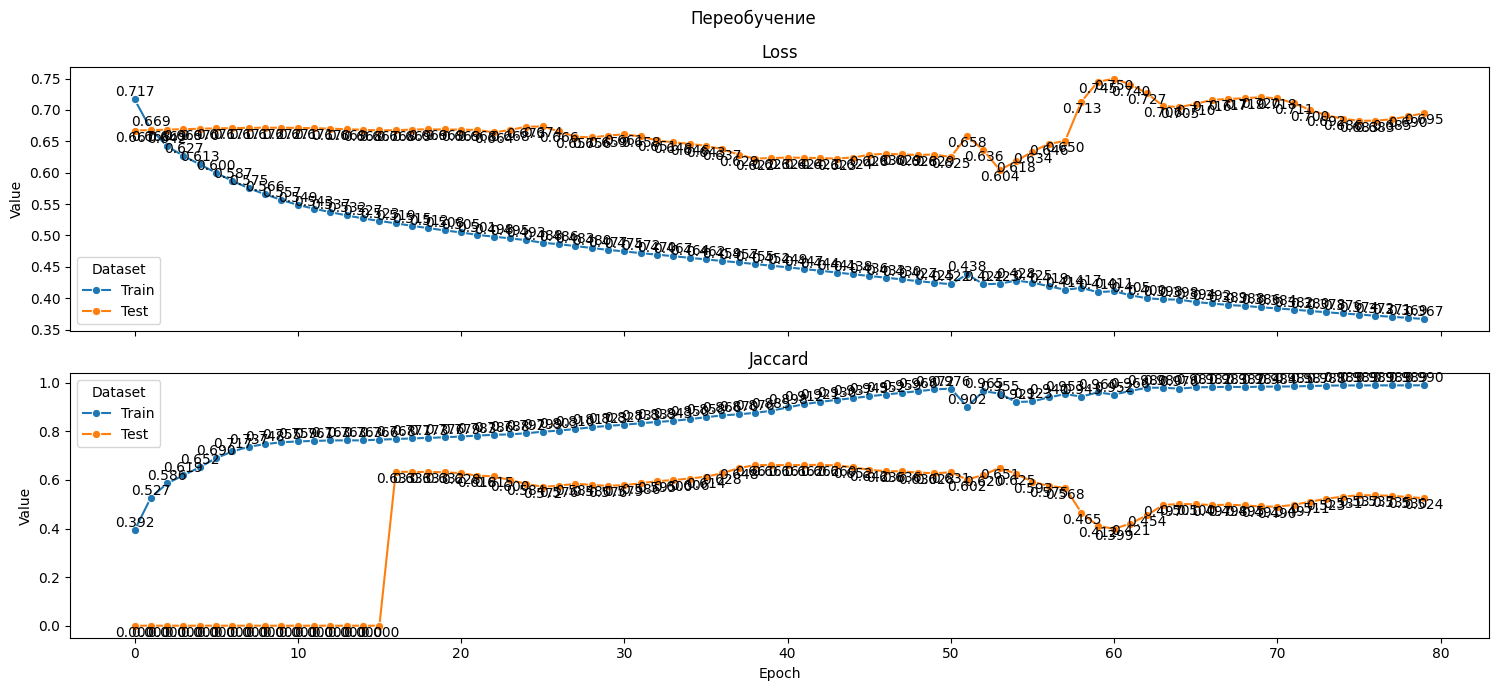

In [38]:
plot_statistics(pd.read_csv("st_overtrain.csv"), "Переобучение")

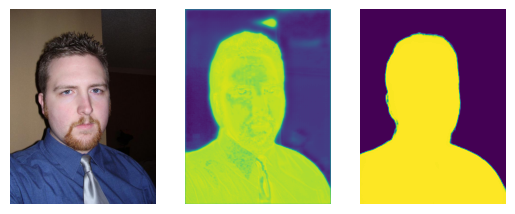

In [ ]:
@torch.no_grad
def display_model_prediction(entry):
    model.eval()
    pred = model(entry[0].cuda().unsqueeze(0))[0].cpu()
    pred = nn.functional.sigmoid(pred)
    display_images([entry[0], pred, entry[1]])

display_model_prediction(test_images[0])
display_model_prediction(train_images[0])

При переобучении, хорошие результаты на одном батче, но плохие на тестовых данных, мы переобучились :(

# Полное обучение

In [ ]:
batch_size = 8

train_loader = DataLoader(train_images, batch_size=batch_size)
test_loader = DataLoader(test_images, batch_size=batch_size)

model = UNET().cuda()
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, train_loader, test_loader, num_epochs=30, save_dir="result/complete").to_csv("result/complete/statistics.csv")

In [39]:
plot_statistics(pd.read_csv("result/complete/statistics.csv"), "Полное обучение")

Модель на 17 эпохе показала лучшие результаты

[117, 10, 161, 119, 168]

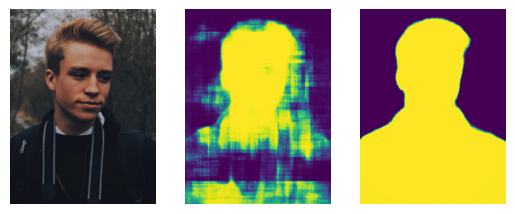

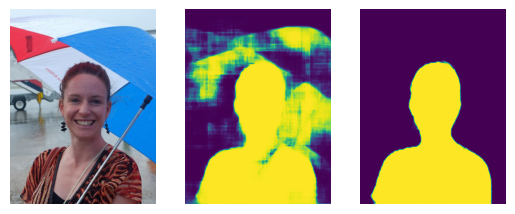

In [40]:
model = UNET()
model.load_state_dict(torch.load("result/complete/epoch_17.pt"))
model.cuda().eval()
show_worst_test_cases(model, n=5)

Есть схожести с масками, но есть наличие глитчей и лишних фигур

# Улучшение качества без изменения архитектуры

## Аугментация

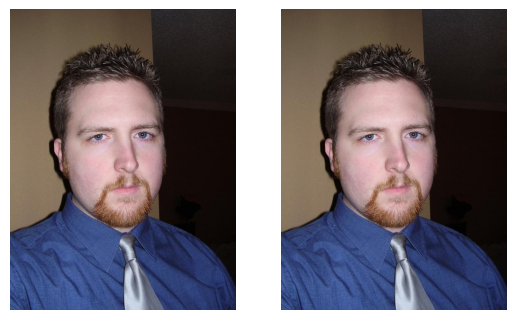

In [ ]:
augmentations = [
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=.05, hue=.05, saturation=.05),
    transforms.RandomAdjustSharpness(sharpness_factor=4),
]

train_images_augmented = copy(train_images)
train_images_augmented.transform_function = augmentations

image = train_images[0][0]
augmented_image = train_images_augmented[0][0]
display_images([image, augmented_image])


In [ ]:
train_images_improved = ConcatDataset([train_images, copy(train_images)])
train_loader_improved  = DataLoader(train_images_improved, batch_size=batch_size, shuffle=True)


In [ ]:
model = UNET().cuda()
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, train_loader_improved, test_loader, num_epochs=30, save_dir="result/improved").to_csv(
    "result/improved/statistics.csv")

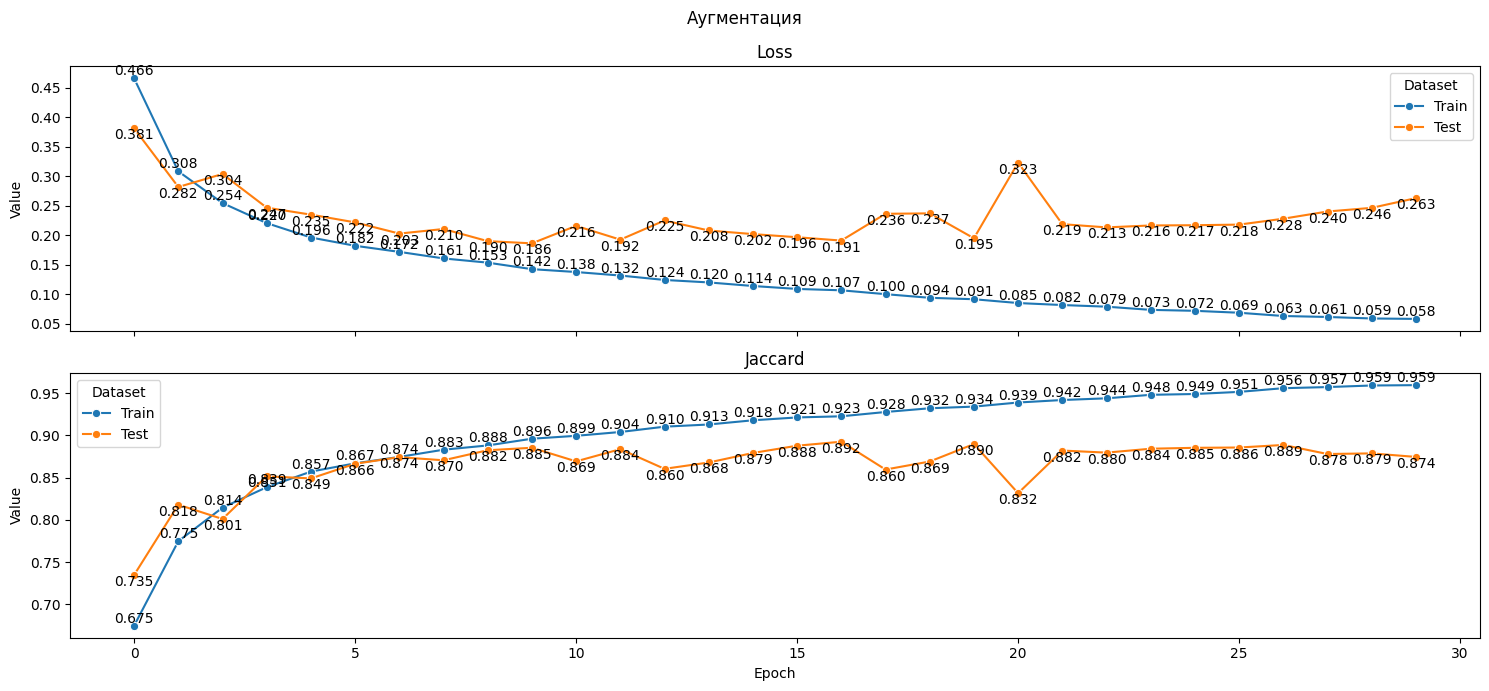

In [41]:
plot_statistics(pd.read_csv("result/improved/statistics.csv"), "Аугментация")

In [ ]:
model = UNET()
model.load_state_dict(torch.load(f"result/improved/epoch_19.pt"))
model.cuda().eval()

[117, 173, 10, 122, 168]

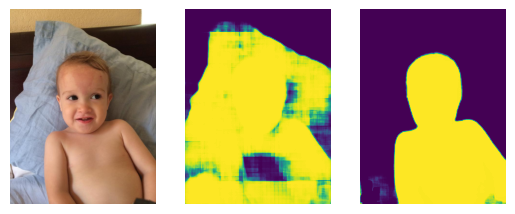

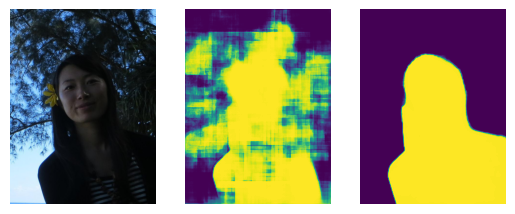

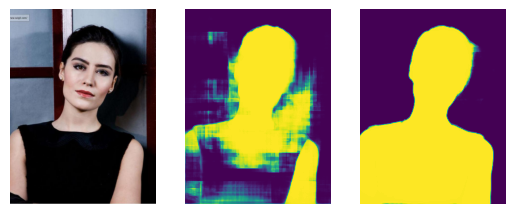

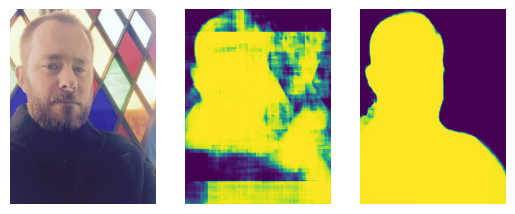

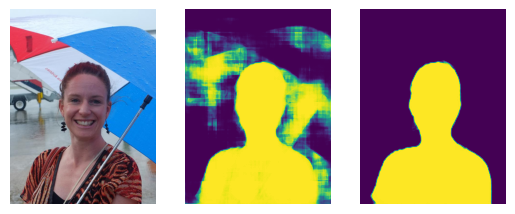

In [47]:
show_worst_test_cases(model, n=5)

Вроде сильно больших изменений не замечено, но все так же различить маску можно, но с лишними элементами

In [ ]:
def train_models_with_various_levels(
    num_epochs,
    ns_levels,
    train_loader,
    test_loader,
    save_dir,
):
    save_dir = Path(save_dir)
    batch_size = 8

    for n_levels in ns_levels:
        model = UNET(n_levels=n_levels).cuda()
        optimizer = torch.optim.Adam(model.parameters())

        model_name = f"{n_levels}_levels"
        (save_dir / model_name).mkdir(parents=True, exist_ok=True)

        if not os.path.isfile(save_dir / model_name / "statistics.csv"):
            statistics = train(
                model, optimizer, train_loader, test_loader,
                num_epochs=num_epochs,
                save_dir=save_dir / model_name,
            )
            statistics.to_csv(save_dir / model_name / "statistics.csv")
        else:
            statistics = pd.read_csv(save_dir / model_name / "statistics.csv")

        plot_statistics(statistics, f"Модель с {n_levels} уровнями")

train_models_with_various_levels(
    num_epochs=30,
    ns_levels=[3, 5],
    train_loader=train_loader_improved,
    test_loader=test_loader,
    save_dir="result/levels",
)


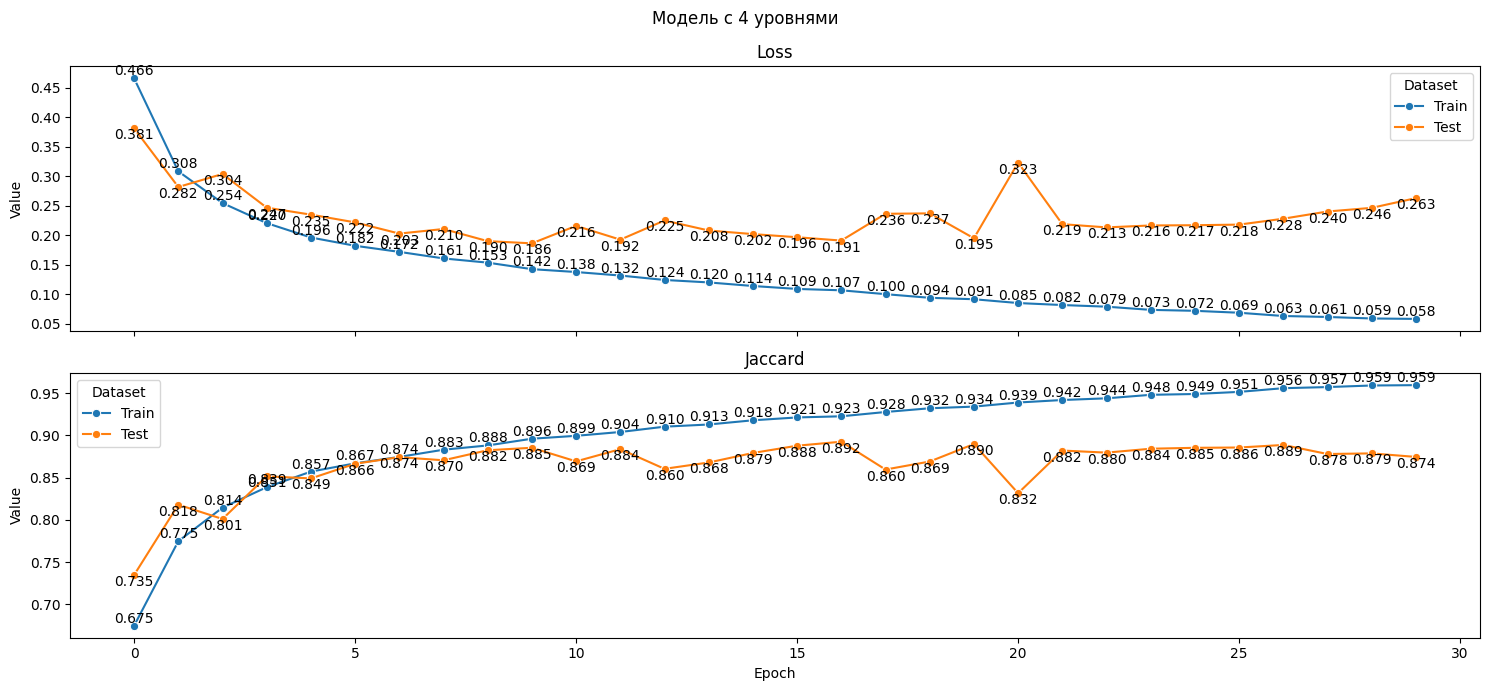

In [ ]:
plot_statistics(pd.read_csv("result/improved/statistics.csv"), "Модель с 4 уровнями")

In [ ]:
model = UNET(n_levels=5)
model.load_state_dict(torch.load(f"result/levels/5_levels/epoch_26.pt"))
model.cuda().eval()

[62, 67, 123, 107, 113]

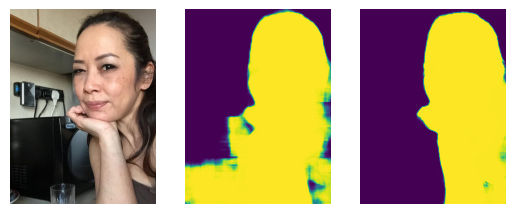

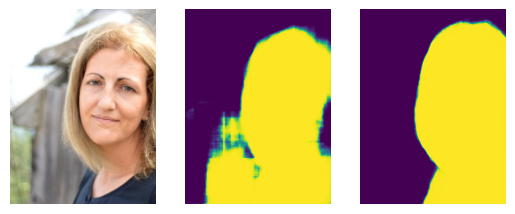

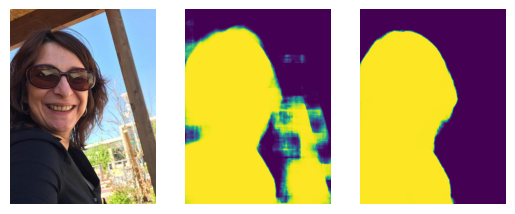

In [51]:
show_worst_test_cases(model, n=5)

Заметим, что даже в тех же изображениях с дополнительными объектами наблюдаются наихудшие результаты. Однако маски, полученные в результате, стали значительно ближе к желаемому исходу, особенно, если сравнивать с первым экспериментом.

# Test-time



In [32]:
class UNetHFlipWrapper(nn.Module):
  def __init__(self, n_levels: int = 4, in_channels: int = 3, out_channels: int = 1):
    super().__init__()
    self.unet = UNET(in_channels, out_channels, n_levels)

  def forward(self, x: torch.Tensor):

    x = torch.cat([x, functional.hflip(x)])
    x = self.unet(x)

    x, x_alt = torch.chunk(x, 2)
    x_alt = functional.hflip(x_alt)

    stacked = torch.stack([x, x_alt])
    means = torch.mean(stacked, dim=0)

    return means

In [52]:
wrap_model = UNetHFlipWrapper(n_levels=5).cuda()
wrap_model.unet.load_state_dict(torch.load(f"result/levels/5_levels/epoch_26.pt"))

<All keys matched successfully>

In [53]:
print("Test-time horizontal flip test results (loss, jaccard): ", test(wrap_model, test_loader))

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Test-time horizontal flip test results (loss, jaccard):  (0.1276552677154541, 0.9352757334709167)


[62, 67, 117, 107, 113]

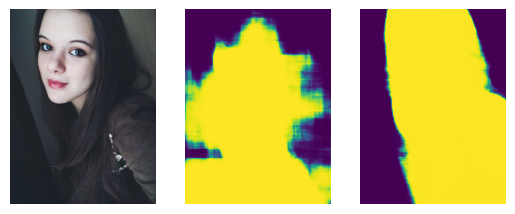

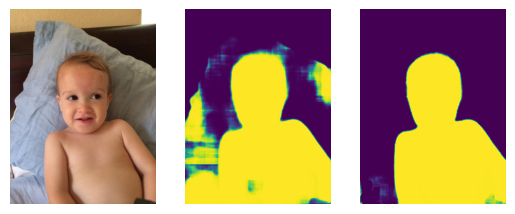

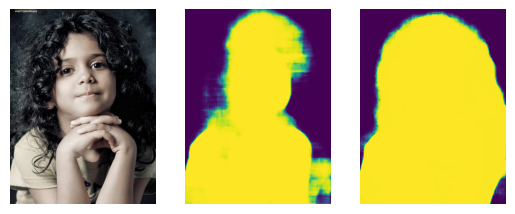

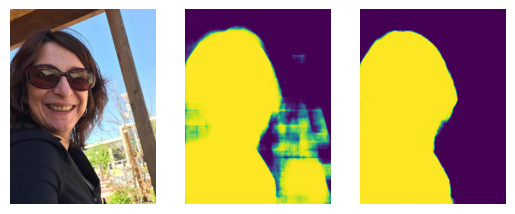

In [54]:
show_worst_test_cases(wrap_model, n=5)

# Улучшение качества с изменение архитектуры

Давайте попробуем увеличить количество сверток в "нижнем" слое U-Net, который имеет наименьшее разрешение, но наибольшее количество каналов. Возможно, это поможет улучшить результаты без увеличения числа уровней сети. Такой подход должен быть более эффективным с вычислительной точки зрения.

In [27]:

class NConvBlock(nn.Module):
    def __init__(self, n_convs, in_channels, out_channels, padding):
        super().__init__()
        convs = []
        for i in range(n_convs):
            convs += [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, padding=padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
        self.n_conv_block = nn.Sequential(*convs)

    def forward(self, x):
        return self.n_conv_block(x)


class LongBottomEncoder(nn.Module):
    def __init__(self, in_channels, n_down, n_bottom_convs, channels_factor=2, padding=1):
        super().__init__()
        self.enc_layers = nn.ModuleList([DoubleConvBlock(in_channels, in_channels * channels_factor, padding)])
        for i in range(n_down):
            in_channels *= channels_factor
            self.enc_layers.append(
                nn.Sequential(
                    nn.MaxPool2d(2, 2),
                    DoubleConvBlock(in_channels, in_channels * channels_factor, padding)
                    if i < n_down - 1 else NConvBlock(n_bottom_convs, in_channels, in_channels * channels_factor, padding)
                )
            )

    def forward(self, x):
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results


class LongBottomUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, n_levels=4, n_bottom_convs=2):
        super().__init__()
        self.encoder = LongBottomEncoder(in_channels=in_channels, n_down=n_levels, n_bottom_convs=n_bottom_convs)
        self.decoder = Decoder(in_channels=in_channels * (2 ** (n_levels + 1)), n_up=n_levels)
        self.out_conv = nn.Conv2d(in_channels=in_channels * 2, out_channels=out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        x = self.out_conv(x)
        return x


Попробуем натренировать модифицированную архитектуру с четырьмя свёртками вместо двух. Тренировать будем четыре уровня на датасете без аугментаций для повышения скорости обучения.


In [ ]:
model = LongBottomUNet(n_bottom_convs=4).cuda()
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, train_loader, test_loader, num_epochs=30, save_dir="result/long_bottom",
).to_csv("result/long_bottom/statistics.csv")


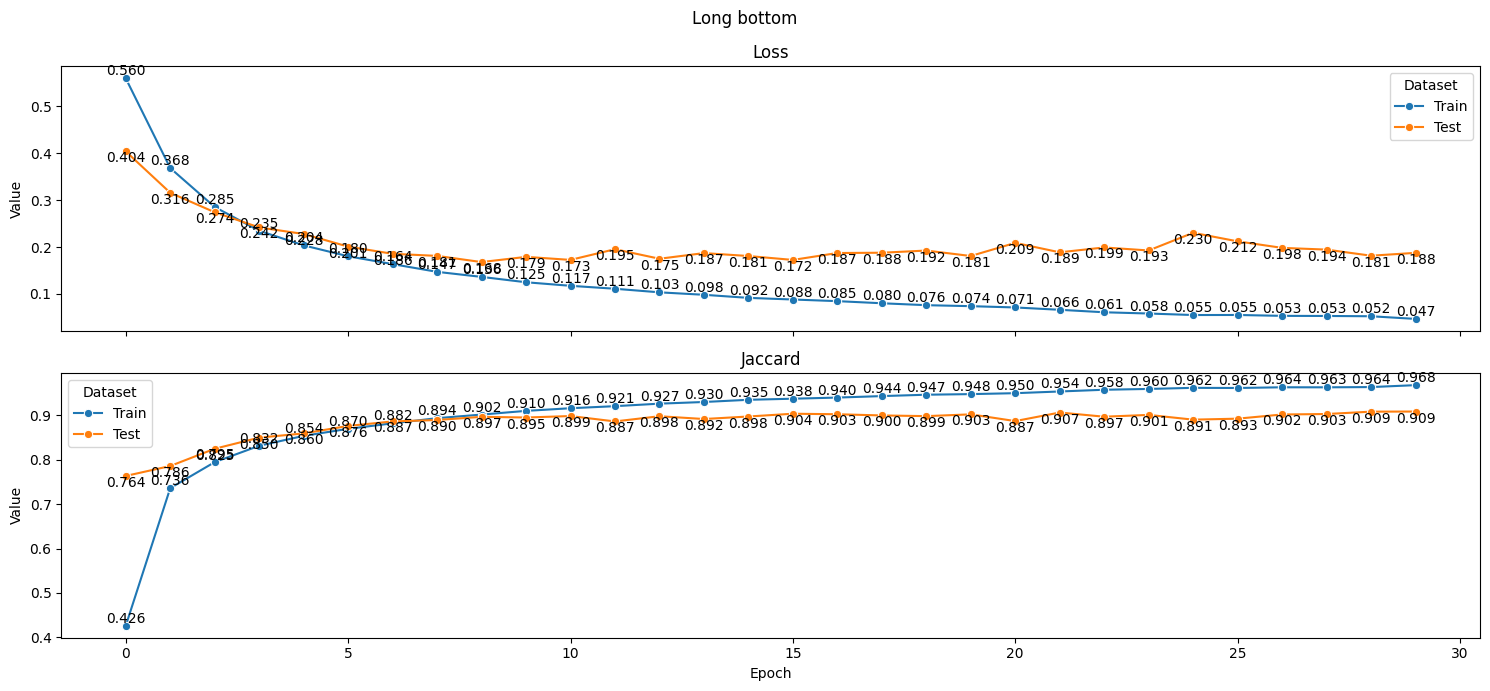

In [30]:
plot_statistics(pd.read_csv("result/long_bottom/statistics.csv"), "Long bottom  уровень (всего 4 уровня), без дополнений к набору данных")

In [ ]:
model = LongBottomUNet(n_bottom_convs=4).cuda()
model.load_state_dict(torch.load(f"result/long_bottom/epoch_27.pt"))
model.eval()

[62, 117, 168, 156, 67]

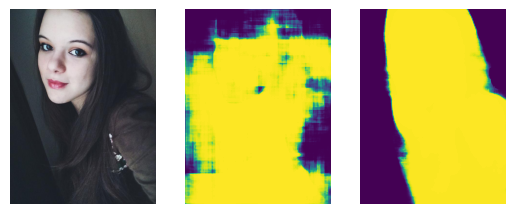

In [29]:
show_worst_test_cases(model, n=5)

Заметно стало лучше в сравнении с полным обучением.

# Resnet34

Давайте воспользуемся предварительно обученным энкодером Resnet34 для тренировки и сравним результаты с полным обучением без аугментации данных.

In [ ]:
%pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [20]:
import segmentation_models_pytorch as smp

In [ ]:
batch_size = 8

resized_train_images = ResizedDataset(train_images)
resized_test_images = ResizedDataset(test_images)

resized_train_loader = DataLoader(resized_train_images, batch_size=batch_size)
resized_test_loader = DataLoader(resized_test_images, batch_size=batch_size)

model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None).cuda()
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, resized_train_loader, resized_test_loader, num_epochs=30, save_dir="result/resnet").to_csv("result/resnet/statistics.csv")


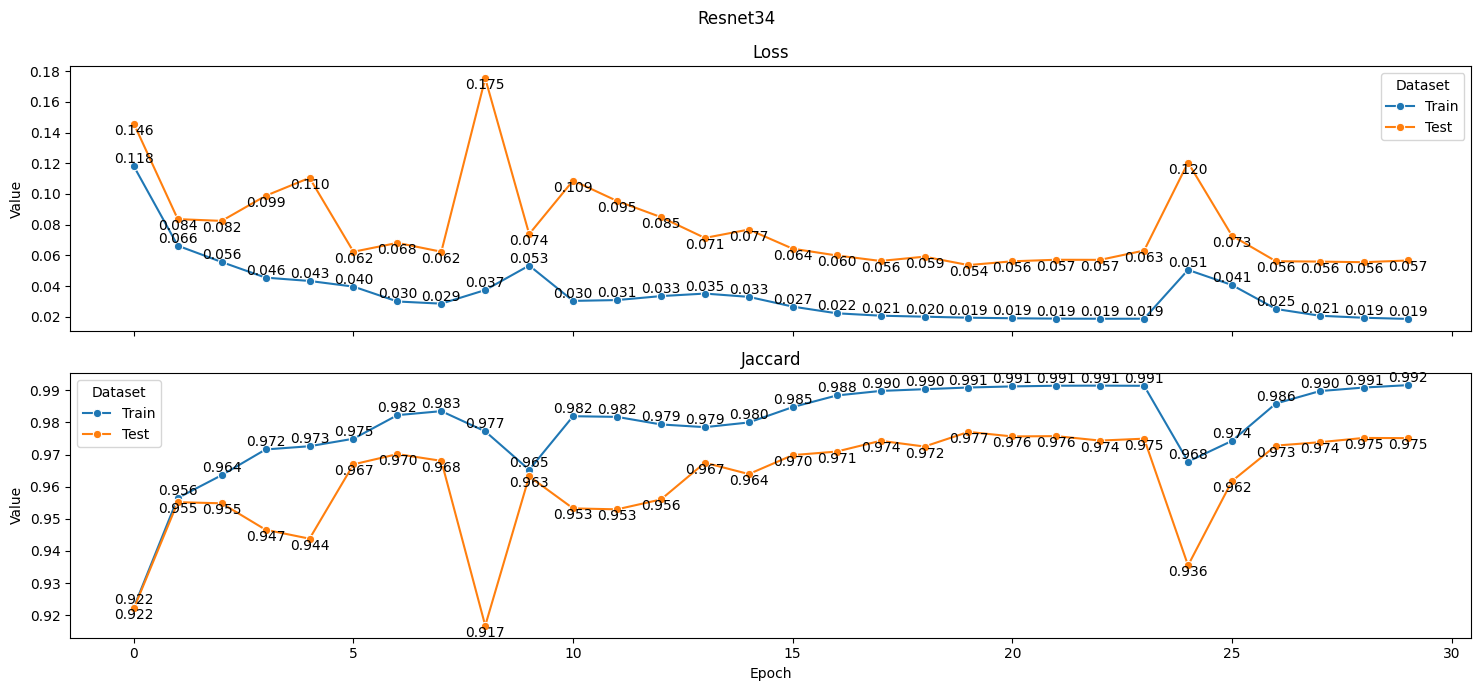

In [23]:
plot_statistics(pd.read_csv("result/resnet/statistics.csv"), "Resnet34")

In [ ]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None).cuda()
model.load_state_dict(torch.load(f"result/resnet/epoch_19.pt"))
model.cuda().eval()

[67, 123, 69, 12, 121]

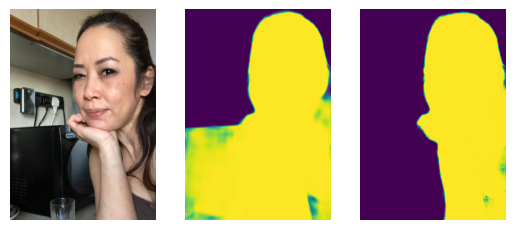

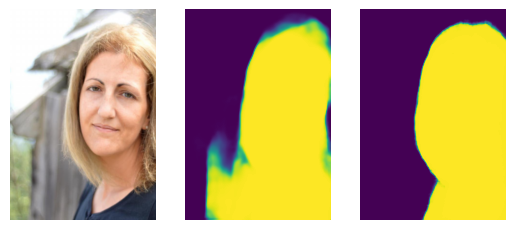

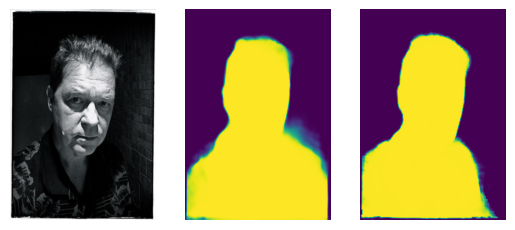

In [79]:
show_worst_test_cases(model, dataset=resized_test_images, n=5)

К сожалению не получилось хорошо обучить с помощью Resnet. Не хватило мощностей ноутбука и пришлось урезать сильно в размере изображения, так как завершалось из-за нехватки памяти. Большой разницы не замечено в результате. Но как по мне самые четкие результаты получились у данной модели.

# Выводы

1. Повышение количества уровней привело к улучшению показателей.
2. Дополнение датасета не принесло прироста, наоборот, даже немного ухудшило результаты. Несмотря на это, визуально маски выглядят лучше.
3. Расширение числа сверточных слоев привело к улучшению метрик.
4. Применение аугментации во время тестирования практически не улучшило результатов.
5. Претрейн энкодер хоть и не дал ощутимого прироста, но все равно считается лучшим даже при урезанных условиях